In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv
import time
import datetime

import networkx as nx

In [2]:
def printProgressBar (iteration, total, prefix = 'Progress: ', suffix = 'Completed', decimals = 1, length = 50, fill = '█'):

    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    styling = f'{prefix} |{fill}| {percent}%% {suffix}'
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s' % styling.replace(fill, bar), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

# Sample Usage
import shutil, time

# A List of Items
items = list(range(0, 57))
l = len(items)

# Initial call to print 0% progress
printProgressBar(0, l)
for i, item in enumerate(items):
    # Do stuff...
    time.sleep(0.03)
    # Update Progress Bar
    printProgressBar(i + 1, l)

Progress:  |██████████████████████████████████████████████████| 100.0%% Completed


In [3]:
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

# Building Knowledge Graph

## Extract Data from CSV

In [4]:
def get_csv_data(filepath, handle_row_func):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        for row in rows:
            handle_row_func(data, row)
    return data

In [5]:
def handle_csv_kanji_func(data, row):
    kanji,*meanings = row
    if len(meanings) >= 2:
        meanings = ",".join(meanings)
    else:
        meanings = meanings[0]
    meanings = meanings.split(":")
    meanings = meanings[0]
    data[kanji] = meanings

In [6]:
data_kanji = get_csv_data("dataset/s5_kanjis_output.csv", handle_csv_kanji_func)
print("len(data_kanji) = ", len(data_kanji))
pp(sample_from_dict(data_kanji))

len(data_kanji) =  6215
{'包': 'wrap',
 '咾': 'voice',
 '弊': 'abuse',
 '涸': 'dry up',
 '磋': 'polish',
 '磬': 'upside-V-shaped gong',
 '紿': 'deceive',
 '緝': 'spin thread',
 '芭': 'banana',
 '駲': "horse's buttocks"}


In [7]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row
    data[radical] = meaning

In [8]:
data_radical = get_csv_data("dataset/s7_nodes_radical_meaning.csv", handle_csv_radical_func)
print("len(data_radical) = ", len(data_radical))
pp(sample_from_dict(data_radical))

len(data_radical) =  255
{'元': 'beginning',
 '小': 'little',
 '廴': 'long stride',
 '弓': 'bow',
 '扌': 'hand',
 '石': 'stone',
 '竹': 'bamboo',
 '里': 'village',
 '長': 'long',
 '韭': 'leek'}


In [9]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    data[kanji] = radical_list.split(':')

In [10]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
pp(sample_from_dict(data_edges))

len(data_edges) =  6215
{'怠': ['厶', '口', '心'],
 '曚': ['冖', '日', '豕', '艹'],
 '橡': ['｜', '勹', '口', '木', '豕'],
 '洌': ['歹', '刂', '氵'],
 '減': ['亅', '口', '戈', '氵'],
 '渝': ['月', '个', '刂', '氵'],
 '渫': ['木', '氵', '世'],
 '磔': ['口', '夕', '木', '石', '舛'],
 '高': ['亠', '冂', '口'],
 '鳶': ['弋', '鳥', '灬']}


## Data Structure

### Node Manager

In [11]:
get_key = lambda symbol, dtype : f"{symbol}-{dtype}"

In [12]:
node_kanji = {
    get_key(symbol, 'kanji'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'red',
    } for symbol, meaning in data_kanji.items()}

In [13]:
node_radical = {
    get_key(symbol, 'radical'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'yellow',
    } for symbol, meaning in data_radical.items()}

In [14]:
full_node = {**node_radical, **node_kanji}
pp(sample_from_dict(full_node))

{'佃-kanji': {'color': 'red',
             'meaning': 'cultivated rice field',
             'symbol': '佃',
             'visual': '佃\ncultivated rice field'},
 '州-kanji': {'color': 'red',
             'meaning': 'state',
             'symbol': '州',
             'visual': '州\nstate'},
 '槨-kanji': {'color': 'red',
             'meaning': 'outer box for a coffin',
             'symbol': '槨',
             'visual': '槨\nouter box for a coffin'},
 '毬-kanji': {'color': 'red',
             'meaning': 'burr',
             'symbol': '毬',
             'visual': '毬\nburr'},
 '洋-kanji': {'color': 'red',
             'meaning': 'ocean',
             'symbol': '洋',
             'visual': '洋\nocean'},
 '淋-kanji': {'color': 'red',
             'meaning': 'lonely',
             'symbol': '淋',
             'visual': '淋\nlonely'},
 '箏-kanji': {'color': 'red',
             'meaning': 'a koto',
             'symbol': '箏',
             'visual': '箏\na koto'},
 '糟-kanji': {'color': 'red',
             'meaning

### Edge Manager

In [15]:
def get_graph_edge(data_edges):
    edges = []
    for kanji, radicals in data_edges.items():
        for r in radicals:
            edges.append( (f"{kanji}-kanji", f"{r}-radical") )
    return edges

full_edges = get_graph_edge(data_edges)
full_edges[:10]

[('亜-kanji', '｜-radical'),
 ('亜-kanji', '口-radical'),
 ('唖-kanji', '｜-radical'),
 ('唖-kanji', '口-radical'),
 ('唖-kanji', '刂-radical'),
 ('逢-kanji', '｜-radical'),
 ('逢-kanji', '二-radical'),
 ('逢-kanji', '夂-radical'),
 ('逢-kanji', '辶-radical'),
 ('悪-kanji', '｜-radical')]

## Kanji Graph

In [34]:
kjg = nx.Graph()

kjg.add_nodes_from(full_node.items())
kjg.add_edges_from(full_edges)

### Graph Visualization

In [17]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [18]:
def visualize_graph(
    Graph: nx.Graph, 
    figsize: tuple=(7,7), 
    color_map: List[str]=None, 
    node_size: int=3000, 
    with_labels: bool=True) -> None:
    
    if color_map == None:
        color_map = [Graph.nodes[n]["color"] for n in Graph] 
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    
    
    labels = nx.get_node_attributes(Graph, 'visual')
    
    nx.draw_kamada_kawai(Graph, 
                         node_color=color_map, 
                         with_labels=with_labels,
                         labels=labels,
                         node_size=node_size, 
                         font_size=20,
                         font_family="Noto Serif CJK JP")
    plt.show()

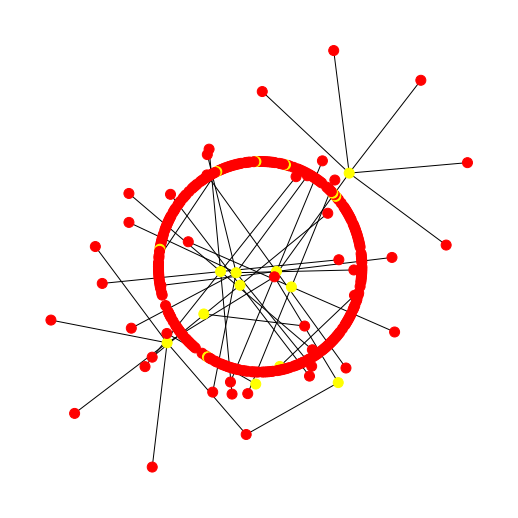

In [31]:
visualize_graph(
    Graph       = kjg.subgraph(random.sample(kjg.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

In [20]:
def get_sg_kanji_with(kjg) -> nx.Graph:
    sg = nx.Graph()
    p = '痘-kanji'
    radicals = [n for n in kjg.neighbors(p)]
    sg.add_nodes_from([(p, kjg.nodes[p])] + [(r, kjg.nodes[r]) for r in radicals])
    sg.add_edges_from([(p, rp) for rp in radicals])
    return sg

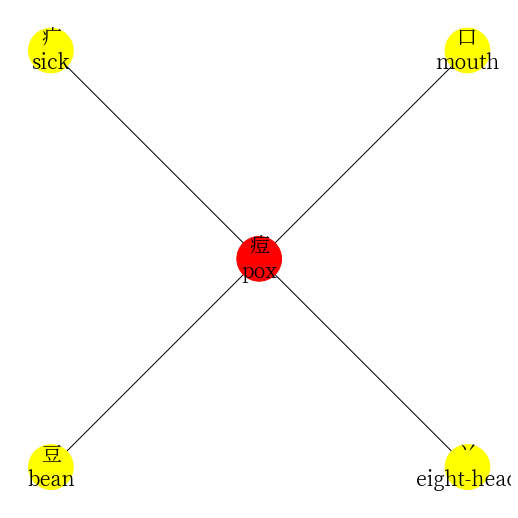

In [30]:
visualize_graph(
    Graph       = get_sg_kanji_with(kjg),
    node_size   = 2000,
)

### Exploratory Data Analysis

In [35]:
print(nx.info(kjg))

Graph with 6470 nodes and 22273 edges


In [36]:
# https://networkx.org/documentation/stable/reference/algorithms/component.html
print('number of connected components: ', nx.number_connected_components(kjg))

number of connected components:  10


In [38]:
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

n_iso = nx.number_of_isolates(kjg)
print('number of isolated: ', n_iso)

assert n_iso >= 1

if n_iso > 1:
    isolated_nodes = [n for n in nx.isolates(kjg)]
    pp(isolated_nodes)
    kjg.remove_nodes_from(list(nx.isolates(kjg)))

n_iso = nx.number_of_isolates(kjg)
if n_iso != 1:
    print(n_iso)
    assert n_iso == 1

number of isolated:  0


AssertionError: 

In [ ]:
print(nx.info(kjg))

print('number of connected components: ', nx.number_connected_components(kjg))

In [ ]:
visualize_graph(
    Graph       = kjg.subgraph(random.sample(kjg.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

### Graph Function

In [ ]:
def generate_graph(G: nx.Graph, nodes: List) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from([(n, G.nodes[n]) for n in nodes])
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [ ]:
def get_node_color_result(g, kinputs, koutputs):
    color_map = []
    for n in g:
        if n in kinputs:
            color_map.append("green") # input
        elif n in koutputs:
            color_map.append("blue")  # output
        else:
            color_map.append(g.nodes[n]["color"])
    return color_map

In [ ]:
def visualize_result(g_res, kinputs, koutputs, figsize=(5,5)):
    visualize_graph(
        Graph=g_res, 
        color_map=get_node_color_result(g_res, kinputs, koutputs), 
        figsize=figsize,
    )

## Graph Alternatives

### Graph Internet

In [ ]:
g_ias = nx.random_internet_as_graph(300, 10)

In [ ]:
nx.set_node_attributes(g_ias, {n: {"visual": n, "color": "yellow"} for n in g_ias.nodes})

visualize_graph(
    Graph       = g_ias,
    node_size   = 500,
    figsize     = (10,10),
    with_labels = True,
)

In [ ]:
kin = 49  # say
kout = 41 # lie 

result_shortest_path = nx.shortest_path(G=g_ias, source=kin, target=kout)
result = generate_graph(g_ias, result_shortest_path)

visualize_result(
    g_res=result, 
    kinputs=[kin],
    koutputs=[kout]
)

## Graph List

In [ ]:
print('number of isolated: ', nx.number_of_isolates(gg['kjg']))

gg = {'kjg': kjg.subgraph(random.sample(kjg.nodes, 300)), 'ias': g_ias}

# Querying Knowledge Graph

## Data Structure

In [ ]:
kin = '語-kanji'  # say
kout = '誕-kanji' # lie 

result_sp = nx.shortest_path(G=kjg, source=kin, target=kout)
result = generate_graph(kjg, result_sp)

visualize_result(
    g_res=result, 
    kinputs=[kin],
    koutputs=[kout]
)

## Algorithm

In [ ]:
MOrig = [40,81,68]
MDest = [26,41,94,88]

### Brute Force Algorithm

In [ ]:
def find_path_bf(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    result = []
    
    for kin in MOrig: # O(|MOrig|)
        for kout in MDest: # O(|MDest|)
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            # O( (|GV|+|GE|) log |GV|)
            
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [ ]:
result = find_path_bf(gg['ias'], MOrig, MDest)
visualize_result(
    g_res=result, 
    kinputs=MOrig,
    koutputs=MDest,
    figsize=(8,8)
)

### Astar Algorithm

#### Heuristic

In [ ]:
g_curr = gg['kjg']

In [ ]:
def common_neighbor_helper(g_curr, u,v):
    neighbor_u = set([n for n in g_curr.neighbors(u)]) # O(1)
    neighbor_v = set([n for n in g_curr.neighbors(v)]) # O(1)
    return len(neighbor_u & neighbor_v)

In [ ]:
def common_neighbor(u, v):
    return common_neighbor_helper(g_curr,u,v)

In [ ]:
def jaccard_similarity(u, v):
    G = g_curr
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return common_neighbor_helper(G,u,v) / union_size

#### Main A* 

In [ ]:
def find_path_astar(G: nx.Graph, MOrig: List, MDest: List, heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig: # O(|MOrig|)
        for kout in MDest: # (|MDest|)
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            # O( (|GV|+|GE|) log |GV|)
            
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [ ]:
# result = find_path_astar(gg['ias'], MOrig, MDest, jaccard_function)
# visualize_result(
#     g_res=result, 
#     kinputs=MOrig,
#     koutputs=MDest,
#     figsize=(8,8)
# )

### Steiner Tree

In [ ]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    # check for connected graph while processing first node
    all_paths_iter = nx.all_pairs_dijkstra(G, weight='weight') # O(|GV|^2)
    u, (distance, path) = next(all_paths_iter)
    if Gnodes - set(distance):
        msg = "G is not a connected graph. metric_closure is not defined."
        raise nx.NetworkXError(msg)
    Gnodes.remove(u)
    for v in Gnodes:
        M.add_edge(u, v, distance=distance[v], path=path[v])

    # first node done -- now process the rest
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [ ]:
mcg = metric_closure(g_curr, weight='weight')

In [ ]:
from itertools import chain
from networkx.utils import pairwise


def my_steiner_tree(G, terminal_nodes, weight="weight", is_mcg=True):
    global mcg
    
    # H is the subgraph induced by terminal_nodes in the metric closure M of G. 
    if is_mcg:
        M = mcg
    else:
        M = metric_closure(G, weight=weight) # O(|GV|^2)
    H = M.subgraph(terminal_nodes) # O(|GV|^2) * O(|MOrig| + |MDest|)
    
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True) # O (|GE| log GV)
    
    
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    

    T = G.edge_subgraph(edges)
    
    return T

In [ ]:
def find_path_steiner(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    return my_steiner_tree(G, MOrig + MDest)

In [ ]:
result = find_path_steiner(gg['ias'], MOrig, MDest)
visualize_result(
    g_res=result, 
    kinputs=MOrig,
    koutputs=MDest,
    figsize=(8,8)
)

# Experiment

## Test Case

In [ ]:
from kanji_lists import JLPT, KYOIKU
# https://github.com/ffe4/kanji-lists

In [ ]:
test_cases_raw = {
#     'N5 to N4': {
#         'MOrig': list(JLPT.N5)[:10],
#         'MDest': list(JLPT.N4)[:10],
#     },
#     'N4 to N3': {
#         'MOrig': list(JLPT.N4)[:30],
#         'MDest': list(JLPT.N3)[:30],
#     },
#     'N3 to N2': {
#         'MOrig': list(JLPT.N3)[:50],
#         'MDest': list(JLPT.N2)[:50],
#     },
#     'N2 to N1': {
#         'MOrig': list(JLPT.N2)[:100],
#         'MDest': list(JLPT.N1)[:100],
#     },
#     'G1 to G2': {
#         'MOrig': KYOIKU.GRADE1,
#         'MDest': KYOIKU.GRADE2,
#     },
#     'G2 to G3': {
#         'MOrig': KYOIKU.GRADE2,
#         'MDest': KYOIKU.GRADE3,
#     },
#     'G3 to G4': {
#         'MOrig': KYOIKU.GRADE3,
#         'MDest': KYOIKU.GRADE4,
#     },
#     'G4 to G5': {
#         'MOrig': KYOIKU.GRADE4,
#         'MDest': KYOIKU.GRADE5,
#     },
#     'G5 to G6': {
#         'MOrig': KYOIKU.GRADE5,
#         'MDest': KYOIKU.GRADE6,
#     },
    
    # gg['ias']
    'tc_ias_1': {
        'MOrig': [1,2,3],
        'MDest': [91,92,93]
    },
    'tc_ias_2': {
        'MOrig': [i*11 for i in range(33)],
        'MDest': [i*10 for i in range(66)]
    },
    'tc_ias_3': {
        'MOrig': [i*12 for i in range(100) if i*12 < 3000],
        'MDest': [i*13 for i in range(200) if i*13 < 3000]
    },
    'tc_ias_4': {
        'MOrig': [i*13 for i in range(200) if i*13 < 3000],
        'MDest': [i*14 for i in range(300) if i*14 < 3000]
    },
    'tc_ias_5': {
        'MOrig': [i*5 for i in range(400) if i*5 < 3000],
        'MDest': [i*7 for i in range(500) if i*7 < 3000]
    },
#     'tc_ias_6': {
#         'MOrig': [i*7 for i in range(600) if i*7 < 3000],
#         'MDest': [i*3 for i in range(700) if i*3 < 3000]
#     },
}
# test_cases_raw

In [ ]:
def tc_filter_in_graph(G, kanji_list):
    
    tc_filtered = []
    for k in kanji_list:

        tk = get_key(k, 'kanji')
        
        if tk in G:
            tc_filtered.append(tk)
            continue
        
        tr = get_key(k, 'radical')
        if tr in G:
            tc_filtered.append(tr)
            continue
            
    return tc_filtered

In [ ]:
def filter_test_cases_raw(G, test_cases_raw):
    test_cases_clean = {}
    for tc_name, tc in test_cases_raw.items():

        MOrig = tc_filter_in_graph(G, tc['MOrig'])
        MDest = tc_filter_in_graph(G, tc['MDest'])

        test_cases_clean[tc_name] = {
            'MOrig': MOrig,
            'MDest': MDest,
        }

    return test_cases_clean

In [ ]:
test_cases_clean = filter_test_cases_raw(g_curr, test_cases_raw)
test_cases_clean = test_cases_raw

In [ ]:
def find_path(G: nx.Graph, MOrig: List, MDest: List, method='brute_force') -> nx.Graph:
    if method == 'brute_force':
        return find_path_bf(G, MOrig, MDest)
    elif method == 'steiner_tree':
        return find_path_steiner(G, MOrig, MDest)
    elif method == 'astar_common_neighbor':
        return find_path_astar(G, MOrig, MDest, common_neighbor)
    elif method == 'astar_jaccard':
        return find_path_astar(G, MOrig, MDest, jaccard_function)
    elif method == 'astar_0':
        return find_path_astar(G, MOrig, MDest, lambda x, y: 0)
    else:
        raise ValueError(f"method {method} is not valid")

## Testing

In [ ]:
def get_result_accuracy(G0, Gt):
    common_nodes = len(G0.nodes() & Gt.nodes())
    G0_nodes     = len(G0.nodes())
    
    return common_nodes / G0_nodes

In [ ]:
def get_results_kanjigen(G: nx.Graph, test_cases_clean: dict, algo_list: List):
    results = {tc_name: dict() for tc_name in test_cases_clean}

    for tc_name, tc in test_cases_clean.items():
        
#         if tc_name != 'tc_ias_1':
#             continue
        
        
        MOrig = tc['MOrig']
        MDest = tc['MDest']
        
        # get time
        for algo in algo_list:
            
            print(f"algo: {algo}")
            print(f"tc: {tc_name} of {len(test_cases_clean)}")
            start  = time.time()
            graph  = find_path(G, MOrig, MDest, algo)
            end    = time.time()
            print(f"finish at {datetime.datetime.now()} after {end - start} seconds")
            print("==============")
            
            results[tc_name][algo] = {'graph': graph, 'time': (end - start)}
        
        # get accuracy
        
        G0 = results[tc_name]['brute_force']['graph']
        results[tc_name]['brute_force']['accuracy'] = 1.0
        for algo in [algo for algo in algo_list if algo != 'brute_force']:
            
            Gt = results[tc_name][algo]['graph']
            
            results[tc_name][algo]["accuracy"] = get_result_accuracy(G0, Gt)
        
        for algo in algo_list:
            Gt = results[tc_name][algo]['graph']
            results[tc_name][algo]["used_vertices"] = len(Gt) - len(MOrig) - len(MDest)
    
    return results

In [ ]:
algo_list = ['brute_force', 'astar_0', 'astar_common_neighbor', 'astar_jaccard', 'steiner_tree']

In [ ]:
algo_list = ['brute_force', 'astar_common_neighbor', 'astar_jaccard', 'steiner_tree']
results = get_results_kanjigen(g_curr, test_cases_clean, algo_list)

In [ ]:
pp(results)

# Analysis

In [ ]:
results

In [ ]:
def get_df_results(results, algo_list):
    df_results = {algo: dict() for algo in algo_list}
    for tc_name, res in results.items():
        
        
        for algo in algo_list:
            if algo not in res:
                continue
            
            if tc_name not in df_results[algo]:
                df_results[algo][tc_name] = dict()
                
            
            df_results[algo][tc_name]['accuracy'] = round(res[algo]['accuracy'], 2)
            df_results[algo][tc_name]['time']     = round(res[algo]['time'], 2)
            df_results[algo][tc_name]['uv']  = res[algo]['used_vertices']

    return df_results

In [ ]:
df_results = get_df_results(results, algo_list)
df_results

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame(df_results)

In [ ]:
df